# Data Pre-processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import shutil
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# 0. Function

In [2]:
# computing the entroy
def get_entropy(proportions):

    return -np.sum(proportions * np.log(proportions))

def data_vis(df, title_name):

    print(f'The entropy of {title_name} :')
    print(get_entropy(df['class'].value_counts(normalize=True)))
    plt.figure(figsize=(12, 6))   
    ax = df['class'].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Class Distribution for {title_name}')
    plt.xlabel('Class')
    plt.ylabel('Relative Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    plt.show()

# Function for data selection
def exclude_data(df_multi, threshold, drop_step=100, expect_entropy=2.8, random_seed=42):
    '''
    df_multi: Input Data Frame 
    threshold：the amount of data expecting to retain
    drop_step：the amount of data to drop for each step, setting it 100 by default
    expect_entropy：expected enthropy to stop the program，2.8 by default
    random_seed: seed for the random number generator, 42 by default
    '''

    # initialization
    df = df_multi.copy()
    current_entropy = get_entropy(df['class'].value_counts(normalize=True))

    entropy_record = []
    print('threshold:', threshold)
    while current_entropy < expect_entropy and len(df.groupby('filename')) > threshold:
        excluded_files = []
        # class with the highest ratio 
        largest_class = df['class'].value_counts().idxmax()
        # class with the lowest ratio
        smallest_class = df['class'].value_counts().idxmin()

        for filename, group in df.groupby('filename'):
            group_classes = group['class'].unique()  
            # the sample contain the highest ratio object except the lowest ratio object
            if largest_class in group_classes and smallest_class not in group_classes:
                excluded_files.append(filename)

        if len(excluded_files) > drop_step:
            excluded_files = random.sample(excluded_files, drop_step)
        else:
            print('Not enough files to exclude, breaking the loop.')
            break

        df = df[~df['filename'].isin(excluded_files)]
        current_entropy = get_entropy(df['class'].value_counts(normalize=True))
        current_sample_size = len(df.groupby('filename'))
        entropy_record.append(current_entropy)
        print('The sum of sample after dropping:', current_sample_size)
        print('current entropy:', current_entropy)

    print('best entropy:', max(entropy_record))
    return df

    

#  1. Data description and indicator selection
The balance of a data set can be assessed by calculating the entropy or Gini coefficient

Indicator description:
- Information entropy (entropy):
> Reference for entropy: https://ieeexplore.ieee.org/document/8703114
> - Entropy is a measure of randomness or uncertainty in a data set. further infomation can be seen in the decision tree
> - In class distribution, the higher the entropy, the higher the uncertainty of the data and the more even the class distribution. (The higher the degree of entropy confusion, the less centralized the data)
> - Generally speaking, high entropy values indicate that the classes are relatively balanced, which is beneficial for training models because the model will not be biased towards any particular minority class.

Based on information entropy as an indicator. The overall person target ratio of the current data exceeds 35%, and the overall information entropy is 2.525

In [3]:
df_select = pd.read_csv('df_trainval.csv')
# print(df_select.columns)
df_select

,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47218,car,19,347,309,461,0,0,0,2011_003269.jpg,334,...,0,0,4.270942,0.868263,0.228000,0.491018,0.808000,-0.141260,-1.478410,0
47219,bottle,98,1,499,405,1,0,0,2011_003271.jpg,500,...,0,0,3.532119,0.802000,0.808000,0.597000,0.406000,-0.220647,-0.213193,0
47220,train,1,113,384,215,1,0,0,2011_003274.jpg,500,...,0,0,6.472539,0.766000,0.272000,0.385000,0.437333,-0.266573,-1.301953,0
47221,aeroplane,42,50,448,282,0,0,0,2011_003275.jpg,500,...,0,0,5.461520,0.812000,0.575682,0.490000,0.411911,-0.208255,-0.552199,0


The entropy of df_select :
2.52492796297772


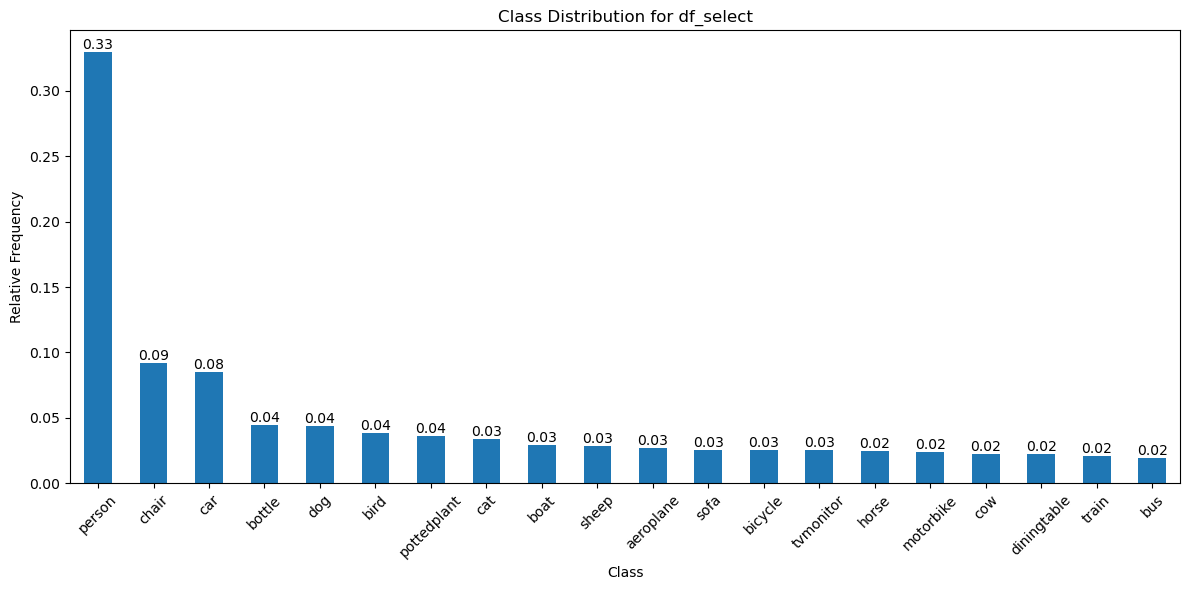

In [4]:
data_vis(df_select, 'df_select')

In [5]:
entropy_original = get_entropy(df_select['class'].value_counts(normalize = True))
entropy_original

2.52492796297772

# 2. Data Spliting

## 2.1 Stratified Shuffle Splitter 
> The performance seems not well, try other methods

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=42)

for train_index, val_index in sss.split(df_select, df_select['class']):
    train_set = df_select.iloc[train_index]
    val_set = df_select.iloc[val_index]

print(f"Training set size: {train_set.shape[0]}")
print(f"Validation set size: {val_set.shape[0]}")

Training set size: 46723
Validation set size: 500


In [7]:
val_set

,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
1736,dog,283,113,496,241,0,0,-1,001127.jpg,500,...,1,0,4.468913,0.426,0.341333,0.779,0.472000,-0.853316,-1.074896,1
38402,diningtable,1,297,500,375,1,0,0,2010_002725.jpg,500,...,1,0,3.215250,0.998,0.208000,0.501,0.896000,-0.002002,-1.570217,3
4020,boat,249,209,305,244,0,0,-1,002605.jpg,500,...,0,0,4.321415,0.112,0.105105,0.554,0.680180,-2.189256,-2.252794,5
33153,boat,128,161,220,195,0,0,0,2009_003732.jpg,500,...,0,0,4.190685,0.184,0.102102,0.348,0.534535,-1.692820,-2.281782,0
38603,train,174,104,456,243,0,0,1,2010_002896.jpg,500,...,0,0,4.139563,0.564,0.417417,0.630,0.521021,-0.572701,-0.873669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25006,person,220,153,233,188,0,1,0,2008_006540.jpg,500,...,1,1,4.376461,0.026,0.105105,0.453,0.512012,-3.649659,-2.252794,5
792,chair,150,128,233,229,1,0,-1,000550.jpg,500,...,1,0,4.075769,0.166,0.269333,0.383,0.476000,-1.795767,-1.311806,4
31034,boat,98,192,168,216,0,0,1,2009_002136.jpg,500,...,1,0,3.660595,0.140,0.064000,0.266,0.544000,-1.966113,-2.748872,0
25557,person,356,229,388,298,0,0,1,2008_006960.jpg,500,...,1,0,2.848336,0.064,0.207831,0.744,0.793675,-2.748872,-1.571028,2


The entropy of val_set :
2.5236837382360924


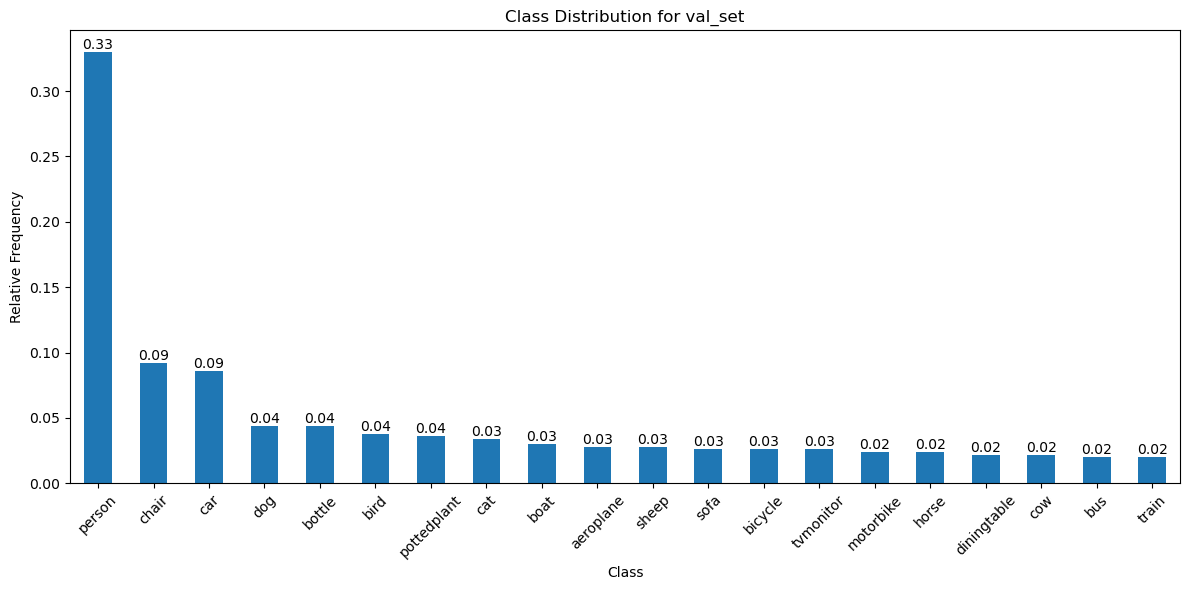

In [8]:
data_vis(val_set, 'val_set')

In [9]:
df_val_1 = df_select[df_select['filename'].isin(val_set['filename'].tolist())]
print('image number of df_val after being selected: ', len(df_val_1.groupby('filename').count()))
df_val_1.reset_index(drop=True)

image number of df_val after being selected:  489


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,dog,1,235,182,388,1,0,-1,000021.jpg,336,...,1,0,3.724556,0.538690,0.306000,0.272321,0.623000,-0.618614,-1.184170,0
1,person,210,36,336,482,0,0,-1,000021.jpg,336,...,1,0,3.724556,0.375000,0.892000,0.812500,0.518000,-0.980829,-0.114289,0
2,person,46,82,170,365,0,0,-1,000021.jpg,336,...,1,0,3.724556,0.369048,0.566000,0.321429,0.447000,-0.996830,-0.569161,0
3,person,11,181,142,419,0,0,-1,000021.jpg,336,...,1,0,3.724556,0.389881,0.476000,0.227679,0.600000,-0.941914,-0.742337,0
4,train,116,167,360,400,1,0,-1,000034.jpg,360,...,0,0,2.135464,0.677778,0.466000,0.661111,0.567000,-0.388936,-0.763570,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,person,1,50,284,375,1,0,0,2011_003255.jpg,500,...,0,0,3.798551,0.566000,0.866667,0.285000,0.566667,-0.569161,-0.143101,0
2829,person,282,1,500,375,1,0,0,2011_003255.jpg,500,...,0,0,3.798551,0.436000,0.997333,0.782000,0.501333,-0.830113,-0.002670,0
2830,dog,246,130,398,218,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.304000,0.234667,0.644000,0.464000,-1.190728,-1.449589,0
2831,dog,5,124,287,265,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.564000,0.376000,0.292000,0.518667,-0.572701,-0.978166,0


The entropy of df_val_1 :
2.301544416870259


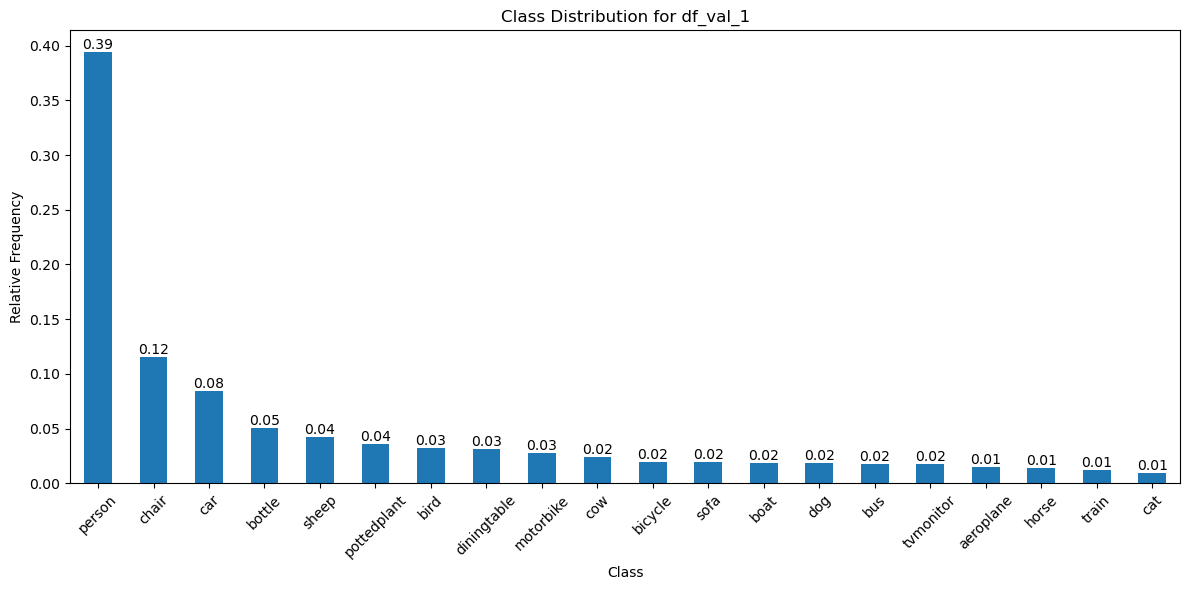

In [10]:
data_vis(df_val_1, 'df_val_1')

In [11]:
get_entropy(df_val_1['class'].value_counts(normalize=True)) - entropy_original
# The entropy increase is not obvious and the effect is not good

-0.22338354610746114

## 2.2 Validation set
> Data set division into single object recognition and multi-object recognition. First divide about 500 image samples as the verification set, and then eliminate them according to filename to divide the training set data.
>
> Given that the number of single-object pictures and the number of multi-object pictures are 6821 and 9730 respectively, accounting for about 40% and 60% respectively, in order to maintain the original distribution, the single-object and multi-object pictures are taken to be 200 and 300 respectively,
>
Finally, 489 samples were obtained, with a total of 1651 recognition objects (bounding boxes), of which 200 were single object recognition samples and the rest were multi-objectt recognition samples. The data is stored in df_val_selected.csv and the sample file is saved in val_image

### 2.2.1 Data spliting for single object sample and multiple object sample

In [12]:
df_single_obj = df_select[df_select['is_multi_object'] == 0][['class','filename']]
df_multi_obj = df_select[df_select['is_multi_object'] == 1][['class','filename','is_multi_class']]
single_obj = len(df_single_obj.groupby('filename'))
mul_obj = len(df_multi_obj.groupby('filename'))
print(f'there are {single_obj} images contains only one object')
print(f'there are {mul_obj} images contains multiple object')

there are 6821 images contains only one object
there are 9730 images contains multiple object


In [13]:
# one-hot encoding, maybe will need it some days...
df_single_obj_encoded = df_single_obj['class'].str.split(',').apply(lambda x: pd.Series(1, index=x)).fillna(0)
df_single_obj_encoded['filename'] = df_single_obj['filename']
df_single_obj_encoded

,car,bicycle,train,dog,tvmonitor,bird,cat,person,aeroplane,boat,...,chair,cow,horse,motorbike,sheep,bottle,pottedplant,sofa,diningtable,filename
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000007.jpg
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000012.jpg
11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000016.jpg
16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000020.jpg
27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000024.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47218,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003269.jpg
47219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2011_003271.jpg
47220,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003274.jpg
47221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003275.jpg


In [14]:
df_multi_obj_encoded = df_multi_obj['class'].str.split(',').apply(lambda x: pd.Series(1, index=x)).fillna(0)
df_multi_obj_encoded['filename'] = df_multi_obj['filename']
df_multi_obj_encoded

,chair,horse,person,cat,dog,bicycle,aeroplane,train,diningtable,tvmonitor,...,bird,bottle,motorbike,pottedplant,boat,sofa,sheep,cow,bus,filename
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000005.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000005.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000005.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000005.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003262.jpg
47214,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003262.jpg
47215,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003262.jpg
47216,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011_003262.jpg


In [15]:
df_multi_obj_encoded.columns

Index(['chair', 'horse', 'person', 'cat', 'dog', 'bicycle', 'aeroplane',
       'train', 'diningtable', 'tvmonitor', 'car', 'bird', 'bottle',
       'motorbike', 'pottedplant', 'boat', 'sofa', 'sheep', 'cow', 'bus',
       'filename'],
      dtype='object')

### 2.2.2 Sampling for single objects 

> In each single object sample, 10 samples of each category are selected as the verification set (that is, a total of 20*10 samples in the verification set of 500 samples are single object recognition)

Among the selected df_single_obj_sampled, they are all single-object samples, which can be regarded as data evenly distributed in class. Its information entropy is 2.99573, which can be used as a reference for distribution uniformity (**that is, constructing a selection criterion—the closer to 2.996, the more uniform the distribution of the data set in class**)

Sampled DataFrame shape: (200, 2)
The entropy of df_single_obj_sampled :
2.995732273553991


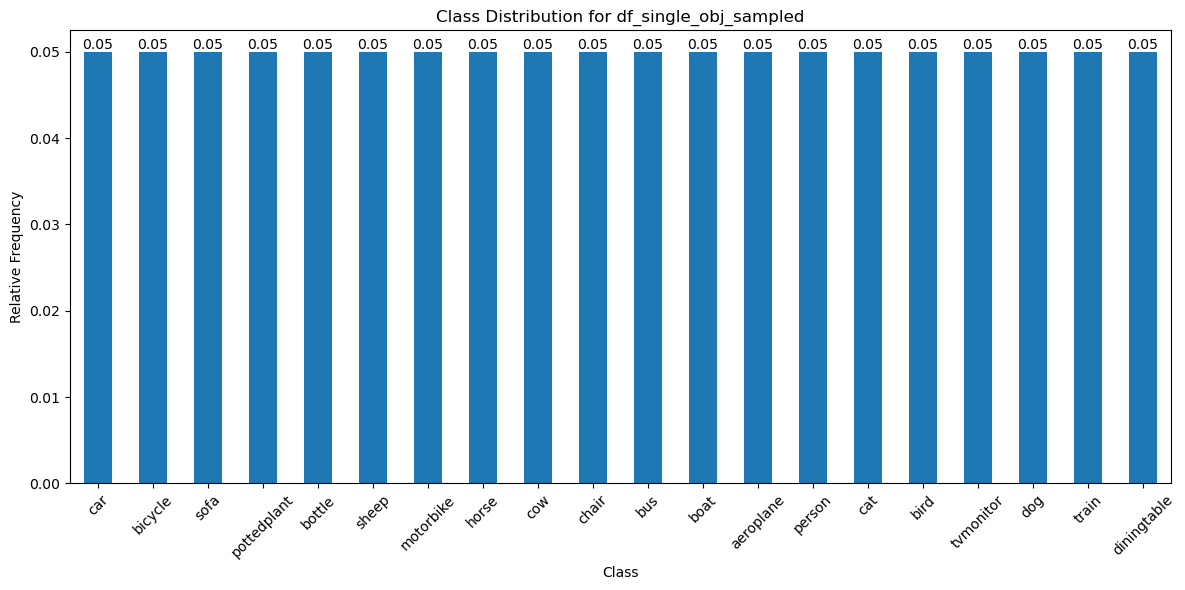

In [16]:
# Define the number of samples for each category
sample_size_per_class = 10

df_single_obj_sampled = pd.DataFrame(columns=df_single_obj.columns)

for label in df_single_obj['class'].unique():
     # Get the number of samples in the current class
     class_samples = df_single_obj[df_single_obj['class'] == label]
    
     # If the number of samples in the current class exceeds the set sampling number, randomly sample
     if len(class_samples) > sample_size_per_class:
         sampled_indices = random.sample(range(len(class_samples)), sample_size_per_class)
         sampled_data = class_samples.iloc[sampled_indices]
     # If the number of samples in the current class is less than the sampling number, add all of them to the sample
     else:
         sampled_data = class_samples
    
     # merge the output
     df_single_obj_sampled = pd.concat([df_single_obj_sampled, sampled_data])

print("Sampled DataFrame shape:", df_single_obj_sampled.shape)
# print(df_single_obj_sampled['class'].value_counts())
data_vis(df_single_obj_sampled, 'df_single_obj_sampled')

In [17]:
df_single_obj_sampled

,class,filename
14050,car,008978.jpg
26302,car,2008_007432.jpg
459,car,000311.jpg
14495,car,009282.jpg
13124,car,008388.jpg
...,...,...
30706,diningtable,2009_001867.jpg
40348,diningtable,2010_004391.jpg
33655,diningtable,2009_004124.jpg
37284,diningtable,2010_001777.jpg


In [18]:

df_single_obj_sampled[df_single_obj_sampled['class']=='dog']

,class,filename
38546,dog,2010_002856.jpg
15733,dog,2008_000053.jpg
11426,dog,007322.jpg
706,dog,000501.jpg
1485,dog,000947.jpg
32006,dog,2009_002865.jpg
26348,dog,2008_007455.jpg
36670,dog,2010_001253.jpg
26366,dog,2008_007471.jpg
37934,dog,2010_002338.jpg


In [19]:
get_entropy(df_single_obj_sampled['class'].value_counts(normalize = True))

2.995732273553991

In [20]:
get_entropy(df_single_obj_sampled['class'].value_counts(normalize = True)) - entropy_original

0.4708043105762707

### 2.2.3 Data selection for multiple objects
There are a total of 9370 pictures and 40402 recognition objects. In view of the current situation of multi-object data, the proportion of the 'person' category is too high, which may cause the model to focus too much on the 'person' category and ignore other class. therefore:
> First perform a simple data elimination for the 'person' category, and then perform random filtering of the data.

Data elimination:
> The proportion of each category has changed significantly.
> - Initially, the 'person' category accounted for the highest proportion, about 36%, while the proportions of other class were relatively low.
> - After excluding the data, the proportion of the 'person' category dropped to about 13%, while the proportions of other class increased, especially the proportions of 'chair', 'car', 'pottedplant' and other class The increase is more obvious.

After data removal:
- The number of samples in each category is more balanced, which will facilitate subsequent random sampling and also facilitate the model's learning and recognition of each category.
- The number of samples of rare class is relatively increased, which helps to improve the model's recognition ability of rare class, thus improving the generalization performance of the model.
> From the perspective of data distribution changes, the data set after data elimination is more suitable for subsequent random sampling and model training.
>

After random elimination, most of the person objects were reduced. Then perform data screening on the data frame after removing random data. 289 samples were obtained by screening based on the reciprocal of the distribution proportion as the weight. **The overall information entropy of the final verification set is 2.777**, which is less than the information entropy of single-object data screening. This may be due to the difficulty in dividing multi-object data well. In view of time constraints and complexity, we will not discuss it in depth.


#### 2.2.3.1 Data inspection on multiple objects samples
- 近六成图片包含person类别
- 在所有单类别多目标图像中（766张图片）超25%的多目标图片仅包含person

- Nearly 60% of the images contain person category
- Among all single-category multi-object images (766 images), more than 25% of the multi-object images contain only person

The entropy of df_multi_obj :
2.401799826189704


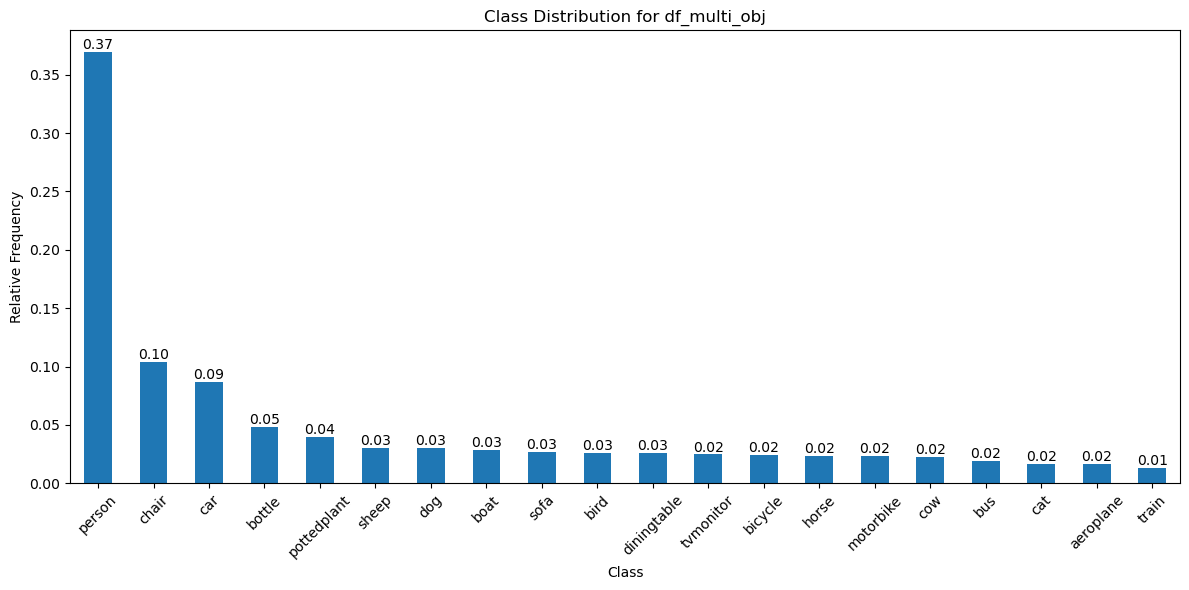

In [21]:
data_vis(df_multi_obj, 'df_multi_obj')

In [22]:
# 近六成图片包含person类别
len(df_multi_obj[df_multi_obj['class'] == 'person'].groupby('filename')) / len(df_multi_obj.groupby('filename'))

0.5986639260020555

In [23]:
# 单类别多目标图像数量
print('the sum of image for a single class with multiple object: ', len(df_multi_obj[df_multi_obj['is_multi_class'] == 0][['class','filename']].groupby('filename')))
df_multi_obj[df_multi_obj['is_multi_class'] == 0]['class'].value_counts()
print('the sum of image for multiple people (without other class): ', 
      len(df_multi_obj[(df_multi_obj['class'] == 'person') & 
          (df_multi_obj['is_multi_class'] == 0)].groupby('filename')))
# 超25%的多目标图片是单只有person存在而不是包含多个类别的
len(df_multi_obj[(df_multi_obj['class'] == 'person') & 
    (df_multi_obj['is_multi_class'] == 0)].groupby('filename')) / len(df_multi_obj[df_multi_obj['is_multi_class'] == 0].groupby('filename'))

the sum of image for a single class with multiple object:  2963
the sum of image for multiple people (without other class):  766


0.25852176847789404

#### 2.2.3.2 orientive Under-sampling method on mulitiple object sample （function is put on 0.）
> The goal of data elimination is to try to balance the number of samples in each category so that bias will not be introduced due to imbalanced samples when training the model.

specific situation:
- Before performing data culling:
> - The original data set contains 9730 pictures, and each picture may contain object of multiple class.
> - The most common category is 'person' (a total of 14932 recognized objects), followed by 'chair', 'car', etc.


- After iterative processing of data culling methods
> - The remaining data set contains 4830 pictures, and the data of nearly half of the pictures has been removed.
> - The number of pictures in other class has increased relatively, especially 'chair', 'car', 'pottedplant', etc.

The main process of data elimination method:

- First calculate the fewest class in the data set, then iterate through each image group,
- If a picture group contains the 'person' category and does not contain the category with the smallest proportion of bounding box values, the picture group will be marked for removal.
- Randomly select a certain number of images to be eliminated to ensure the balance of the data set after elimination.
- Calculate the number of each category in the data set after elimination, and check whether the conditions for stopping elimination are met. If the conditions are met, stop eliminating, otherwise continue to repeat the above steps.

The advantages of this method are:
> It can balance the number of samples of each category in the data set to a certain extent, thereby improving the effect of model training. At the same time, the random selection of images to be eliminated can ensure the randomness of the samples and avoid over-reliance on specific elimination strategies.

Possible disadvantages:
> - The elimination strategy based on the number of class may cause some samples of rare class to be excessively eliminated, thus affecting the learning effect of the model for rare class.
> - The way of randomly selecting images to be eliminated may cause some important samples to be mistakenly eliminated, thus affecting the generalization ability of the model.
> - During the elimination process, the elimination conditions need to be continuously adjusted, which requires manual adjustments and attempts, which is more cumbersome.

In short, although this method can (intuitively) solve the problem of data imbalance to a certain extent, there are still areas for improvement.


In [24]:

df_multi_select = df_multi_obj.copy()
# df_multi_select['exclude'] = False
df_multi_select_filegroup = df_multi_select.groupby('filename')
original_len = len(df_multi_select.groupby('filename'))
df_multi_select

,class,filename,is_multi_class
0,chair,000005.jpg,0
1,chair,000005.jpg,0
2,chair,000005.jpg,0
3,chair,000005.jpg,0
4,chair,000005.jpg,0
...,...,...,...
47213,person,2011_003262.jpg,1
47214,person,2011_003262.jpg,1
47215,person,2011_003262.jpg,1
47216,person,2011_003262.jpg,1


In [25]:
remaining_filenames = exclude_data(df_multi_select, original_len/2)

threshold: 4865.0
The sum of sample after dropping: 9630
current entropy: 2.4065474231647
The sum of sample after dropping: 9530
current entropy: 2.412457678289508
The sum of sample after dropping: 9430
current entropy: 2.417233502836253
The sum of sample after dropping: 9330
current entropy: 2.421973620048015
The sum of sample after dropping: 9230
current entropy: 2.4289659695033836
The sum of sample after dropping: 9130
current entropy: 2.4331978313525973
The sum of sample after dropping: 9030
current entropy: 2.4395783925235515
The sum of sample after dropping: 8930
current entropy: 2.4462339635156716
The sum of sample after dropping: 8830
current entropy: 2.452004421890847
The sum of sample after dropping: 8730
current entropy: 2.4568791572863478
The sum of sample after dropping: 8630
current entropy: 2.4631212746513755
The sum of sample after dropping: 8530
current entropy: 2.469762290577884
The sum of sample after dropping: 8430
current entropy: 2.4753504268110085
The sum of samp

In [26]:
remaining_filenames

,class,filename,is_multi_class
0,chair,000005.jpg,0
1,chair,000005.jpg,0
2,chair,000005.jpg,0
3,chair,000005.jpg,0
4,chair,000005.jpg,0
...,...,...,...
47199,person,2011_003260.jpg,1
47200,person,2011_003260.jpg,1
47201,person,2011_003260.jpg,1
47202,bicycle,2011_003261.jpg,1


#### 2.2.3.3 Re-sampling base on weight
> Randomly screen the multi-object data after data elimination based on the inverse of the proportion of its category in the overall entropy as the weight.
>
Finally, 289 samples were screened out, and the data were stored in df_multi_val. It will then be merged with the single object data to obtain the validation set.

In [27]:
class_distribution = pd.concat([remaining_filenames['class'].value_counts(), remaining_filenames['class'].value_counts(normalize=True)], axis=1)
class_distribution.columns = ['Counts', 'Proportion']
class_distribution

,Counts,Proportion
class,,
person,2650,0.144422
chair,2558,0.139408
car,2092,0.114012
pottedplant,1162,0.063328
sheep,1073,0.058477
bird,907,0.049430
bottle,862,0.046978
boat,771,0.042019
dog,728,0.039675


The entropy of the df after Randomly Dropping on Person Class :
2.7751359107026223


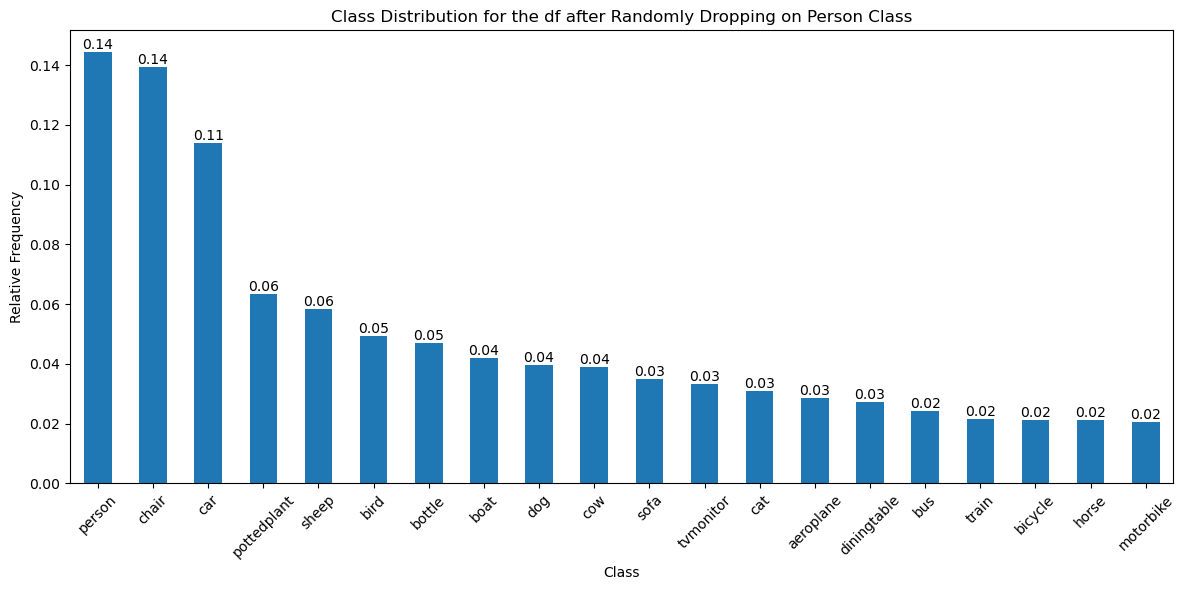

In [28]:
data_vis(remaining_filenames, 'the df after Randomly Dropping on Person Class')


In [29]:
get_entropy(remaining_filenames['class'].value_counts(normalize=True)) - entropy_original

0.2502079477249022

In [30]:
df_multi_val = remaining_filenames.copy()
# calculate the weight of each class (the repiprocal of the proportion)
class_distribution['class_weight'] = 1 / class_distribution['Proportion']
df_multi_val['class_weight'] = df_multi_val['class'].map(class_distribution['class_weight'])
print('weight for each class：')
class_distribution['class_weight'] 


weight for each class：


class
person          6.924151
chair           7.173182
car             8.771033
pottedplant    15.790878
sheep          17.100652
bird           20.230430
bottle         21.286543
boat           23.798962
dog            25.204670
cow            25.734923
sofa           28.580997
tvmonitor      29.982026
cat            32.361552
aeroplane      35.151341
diningtable    36.845382
bus            41.326577
train          46.689567
bicycle        47.169666
horse          47.291237
motorbike      48.542328
Name: class_weight, dtype: float64

In [31]:
i = 44
# sampling by weight
sampled_data = df_multi_val.sample(n=300, weights='class_weight', replace=True, random_state=i)

print('image number of df_val after being selected: ', len(sampled_data.groupby('filename').count()))
sampled_data['class'].value_counts()

image number of df_val after being selected:  285


class
train          20
horse          20
bird           20
pottedplant    19
person         18
dog            17
diningtable    16
sheep          16
boat           16
bottle         15
bus            15
tvmonitor      14
aeroplane      14
cow            13
car            13
chair          13
cat            12
sofa           12
bicycle         9
motorbike       8
Name: count, dtype: int64

In [32]:
df_multi_val = df_multi_obj[df_multi_obj['filename'].isin(sampled_data['filename'].tolist())]
print('image number of df_multi_val after being selected: ', len(df_multi_val.groupby('filename').count()))
df_multi_val['class'].value_counts()

image number of df_multi_val after being selected:  285


class
person         173
chair          161
pottedplant    155
sheep          135
bottle         112
car            106
bird            84
boat            76
cow             60
tvmonitor       57
bus             54
horse           48
train           44
dog             43
sofa            40
diningtable     40
aeroplane       37
motorbike       29
cat             24
bicycle         23
Name: count, dtype: int64

In [33]:
get_entropy(sampled_data['class'].value_counts(normalize=True))

2.969848129643973

In [34]:
get_entropy(df_multi_val['class'].value_counts(normalize=True))

2.8115429353548036

In [35]:
get_entropy(df_multi_val['class'].value_counts(normalize=True)) - entropy_original

0.28661497237708344

In [36]:
df_multi_val

,class,filename,is_multi_class
14,cat,000019.jpg,0
15,cat,000019.jpg,0
100,dog,000078.jpg,0
101,dog,000078.jpg,0
317,tvmonitor,000224.jpg,1
...,...,...,...
47094,aeroplane,2011_003176.jpg,1
47095,aeroplane,2011_003176.jpg,1
47096,aeroplane,2011_003176.jpg,1
47097,aeroplane,2011_003176.jpg,1


### 2.2.4 outputing the validation set

In [37]:
val_file_list = df_multi_val['filename'].tolist()
val_file_list.extend(df_single_obj_sampled['filename'].tolist())
df_val = df_select[df_select['filename'].isin(val_file_list)]
print('Sample size of validation set：', len(df_val.groupby('filename')))
df_val.reset_index(drop=True)

Sample size of validation set： 485


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,cat,231,88,483,256,0,0,-1,000019.jpg,500,...,0,0,4.187238,0.504,0.448000,0.714,0.458667,-0.685179,-0.802962,0
1,cat,11,113,266,259,0,0,-1,000019.jpg,500,...,0,0,4.187238,0.510,0.389333,0.277,0.496000,-0.673345,-0.943319,0
2,dog,15,75,475,412,0,0,-1,000078.jpg,500,...,0,0,5.289722,0.920,0.804296,0.490,0.581146,-0.083382,-0.217788,0
3,dog,94,41,437,238,0,0,-1,000078.jpg,500,...,0,0,5.289722,0.686,0.470167,0.531,0.332936,-0.376878,-0.754667,0
4,horse,205,1,500,375,1,0,-1,000214.jpg,500,...,0,0,2.984179,0.590,0.997333,0.705,0.501333,-0.527633,-0.002670,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,aeroplane,399,175,482,225,1,1,1,2011_003176.jpg,500,...,1,0,4.879712,0.166,0.150602,0.881,0.602410,-1.795767,-1.893112,3
1697,aeroplane,363,151,454,214,1,1,1,2011_003176.jpg,500,...,1,0,4.879712,0.182,0.189759,0.817,0.549699,-1.703749,-1.662000,3
1698,aeroplane,312,186,448,218,1,1,1,2011_003176.jpg,500,...,1,0,4.879712,0.272,0.096386,0.760,0.608434,-1.301953,-2.339399,3
1699,aeroplane,31,78,472,231,0,0,0,2011_003176.jpg,500,...,1,0,4.879712,0.882,0.460843,0.503,0.465361,-0.125563,-0.774697,3


In [38]:
df_val.to_csv('df_val_selected.csv', encoding = 'utf-8', index = False)

In [39]:
source_folder = 'JPEGImages'
destination_folder = 'val_image'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

for filename in df_val['filename']:
    source_file_path = os.path.join(source_folder, filename)
    destination_file_path = os.path.join(destination_folder, filename)
    shutil.copy(source_file_path, destination_file_path)
print("Complect")


Complect


## 2.3 Test set
> Test set files based on Pascal voc 2007, randomly selected

In [40]:
df_test = pd.read_csv('df_test.csv')
df_test['class'].value_counts()

class
person         5227
car            1541
chair          1374
bottle          657
pottedplant     592
bird            576
dog             530
sofa            396
horse           395
boat            393
bicycle         389
cat             370
motorbike       369
tvmonitor       361
cow             329
sheep           311
aeroplane       311
train           302
diningtable     299
bus             254
Name: count, dtype: int64

In [41]:
get_entropy(df_test['class'].value_counts(normalize=True))

2.4545490697309376

In [42]:
path_test = r'test_07\ImageSets\Main\test.txt'
with open(path_test, 'r') as file:
    test_filename = [line.strip() + '.jpg' for line in file.readlines()]

len(test_filename)

4952

In [43]:
# random select 500 samples
random.seed(44)
selected_filenames = random.sample(test_filename, 500)

df_test_selected = df_test[df_test['filename'].isin(selected_filenames)]

print("Number of samples in the test set:", len(df_test_selected))
df_test_selected.reset_index(drop=True)

Number of samples in the test set: 1556


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_object,img_size,is_multi_class,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,dog,48,240,195,371,1,0,-1,000001.jpg,353,...,1,176500,1,0.416431,0.262000,0.344193,0.611000,-0.876035,-1.339411,0
1,person,8,12,352,498,1,0,-1,000001.jpg,353,...,1,176500,1,0.974504,0.972000,0.509915,0.510000,-0.025826,-0.028399,0
2,car,58,61,475,283,0,0,-1,000074.jpg,500,...,0,187500,0,0.834000,0.592000,0.533000,0.458667,-0.181522,-0.524249,0
3,person,63,78,265,375,1,0,-1,000076.jpg,500,...,1,187500,0,0.404000,0.792000,0.328000,0.604000,-0.906340,-0.233194,0
4,person,257,75,448,375,1,0,-1,000076.jpg,500,...,1,187500,0,0.382000,0.800000,0.705000,0.600000,-0.962335,-0.223144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,car,33,103,488,266,0,0,-1,009883.jpg,500,...,0,187500,0,0.910000,0.434667,0.521000,0.492000,-0.094311,-0.833176,0
1552,bottle,22,1,125,188,1,0,-1,009891.jpg,500,...,0,166500,0,0.206000,0.561562,0.147000,0.283784,-1.579879,-0.577034,0
1553,bicycle,27,84,491,349,0,0,-1,009953.jpg,500,...,0,187500,0,0.928000,0.706667,0.518000,0.577333,-0.074724,-0.347196,0
1554,person,106,89,236,308,0,0,-1,009957.jpg,353,...,1,169440,1,0.368272,0.456250,0.484419,0.413542,-0.998934,-0.784714,0


In [44]:
get_entropy(df_test_selected['class'].value_counts(normalize=True))

2.489377169381453

In [45]:
for filename in df_test_selected['filename']:
    source_file_path = os.path.join(r'test_07\JPEGImages', filename)
    destination_file_path = os.path.join('test_image', filename)
    shutil.copy(source_file_path, destination_file_path)
print("complect！")

complect！


In [46]:
df_test_selected.to_csv('df_test_selected.csv', encoding = 'utf-8', index = False)


## 2.4 Training set
- It is necessary to ensure that the training set can represent the diversity of the entire data set and maintain the consistency of the category distribution, which can avoid the trained model being biased towards certain class, resulting in poor generalization ability.
- To ensure that the class distributions of the training set and the validation set are inconsistent, we conduct the same process of under-sampling process during the selection of training data set.

specific process:

- Perform the same under-sampling as the validation set (to reduce the proportion of person samples)

> The best approach is to try different filter_size values and evaluate based on actual model training results and performance.
- Extract data above the mean based on niqe scores
> The sample size is halved and samples with low image quality are eliminated. However, if the image quality of a certain category is generally low (such as the aeroplane category, it may be due to the problem of shooting pixels), this may introduce bias. (That is, it is possible that the accuracy of recognition of distant fuzzy objects, such as small object, etc., is not high)
- Perform data augmentation

Final state:
- Obtained the data set df_niqe_select based on the under-sampling rules, with a total of 2236 samples (4397 objects) and an entropy of 2.908 (the class distribution are relatively uniform). The number of single/multi-object samples are: 857 and 1379 respectively, which is close to the original ratio.
- The output is csv, which can be tested given that this data set is in principle performed to solve the class imbalance problem

### 2.4.1 Data Description
> - df_not_val, 16062 samples with a total of 45572 recognition object. The overall entropy is about 2.506. Observing the category distribution histogram, there is data imbalance.
> - The number of single-object samples is 6621 (accounting for 0.41 of the total sample size), the number of multi-object samples: 9441 (accounting for 0.59 of the total sample size)
> - Compared with the single-object situation (entropy is 2.68), the multi-object imbalance is more serious (entropy is 2.38)
> - The person category of multi-object data accounts for more than 38%, compared with the second highest chair category, which exceeds 28%. Data needs to be eliminated for multi-object data.

In [47]:
df_not_val = pd.read_csv('df_not_val.csv')
print('image number of df_not_val: ', len(df_not_val.groupby('filename').count()))
# df_not_val = df_select[~df_select['filename'].isin(val_file_list)]
# df_not_val.reset_index(drop=True)
df_not_val

image number of df_not_val:  16062


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45567,car,19,347,309,461,0,0,0,2011_003269.jpg,334,...,0,0,4.270942,0.868263,0.228000,0.491018,0.808000,-0.141260,-1.478410,0
45568,bottle,98,1,499,405,1,0,0,2011_003271.jpg,500,...,0,0,3.532119,0.802000,0.808000,0.597000,0.406000,-0.220647,-0.213193,0
45569,train,1,113,384,215,1,0,0,2011_003274.jpg,500,...,0,0,6.472539,0.766000,0.272000,0.385000,0.437333,-0.266573,-1.301953,0
45570,aeroplane,42,50,448,282,0,0,0,2011_003275.jpg,500,...,0,0,5.461520,0.812000,0.575682,0.490000,0.411911,-0.208255,-0.552199,0


In [48]:
get_entropy(df_not_val['class'].value_counts(normalize=True))

2.5058930024688544

The entropy of df_not_val :
2.5058930024688544


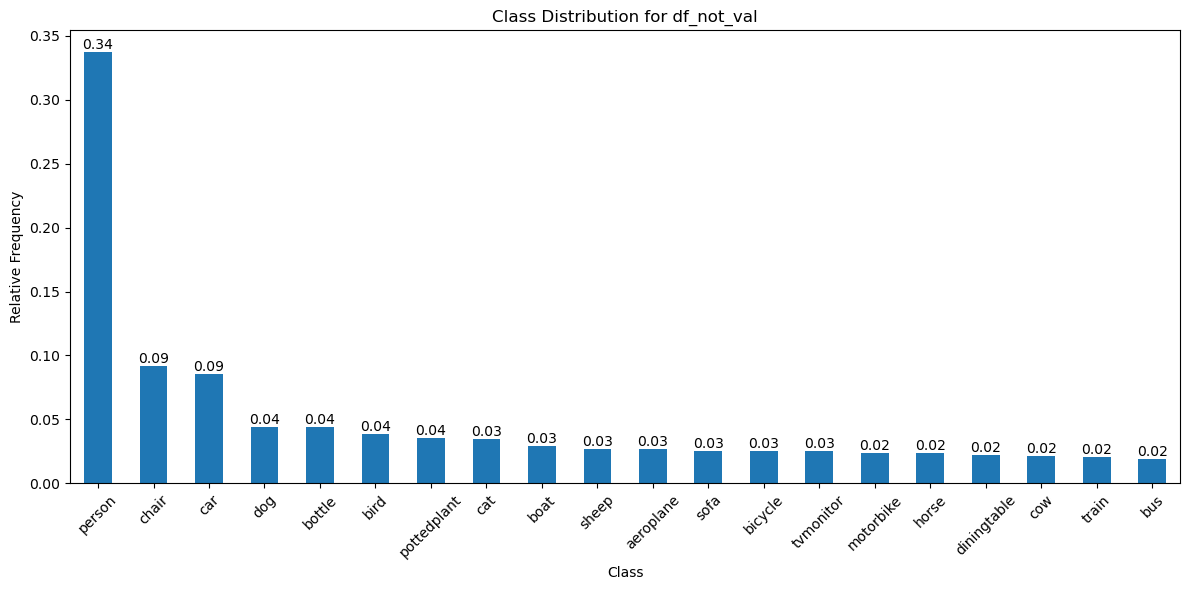

In [49]:
data_vis(df_not_val, 'df_not_val')

In [50]:
df_train_single = df_not_val[df_not_val['is_multi_object'] == 0]
df_train_multi = df_not_val[df_not_val['is_multi_object'] == 1]
single_obj = len(df_train_single.groupby('filename'))
mul_obj = len(df_train_multi.groupby('filename'))
print(f'there are {single_obj} images contains only one object')
print(f'there are {mul_obj} images contains multiple object')

there are 6621 images contains only one object
there are 9441 images contains multiple object


The entropy of df_train_single :
2.675408297806416


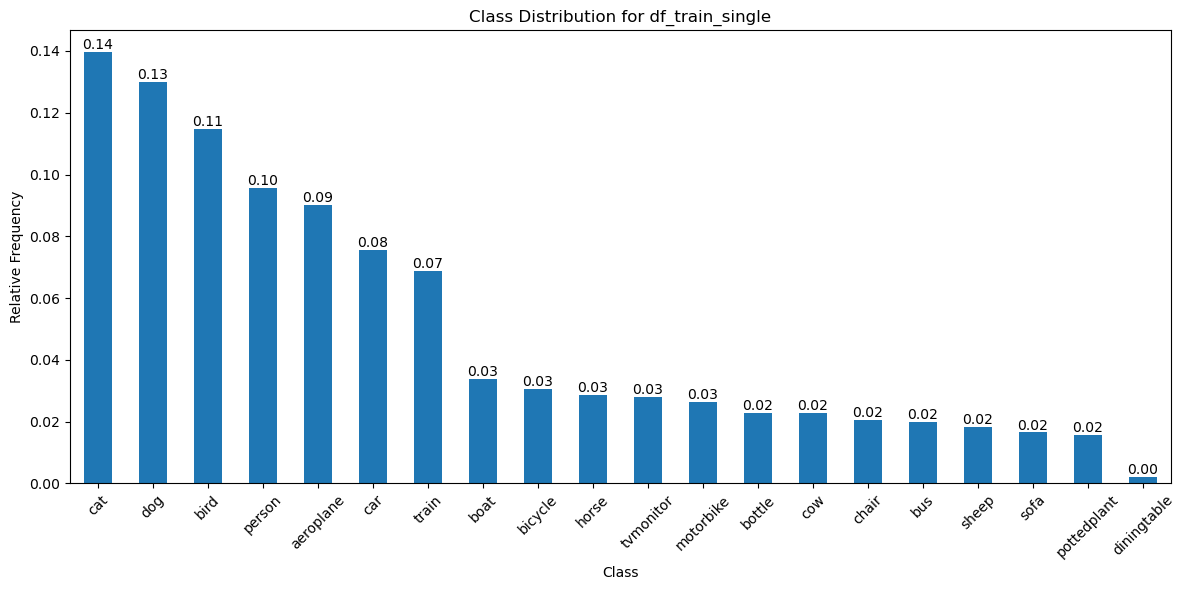

In [51]:
# low proportion of diningtable class
data_vis(df_train_single,'df_train_single')

The entropy of df_train_multi :
2.377618864973303


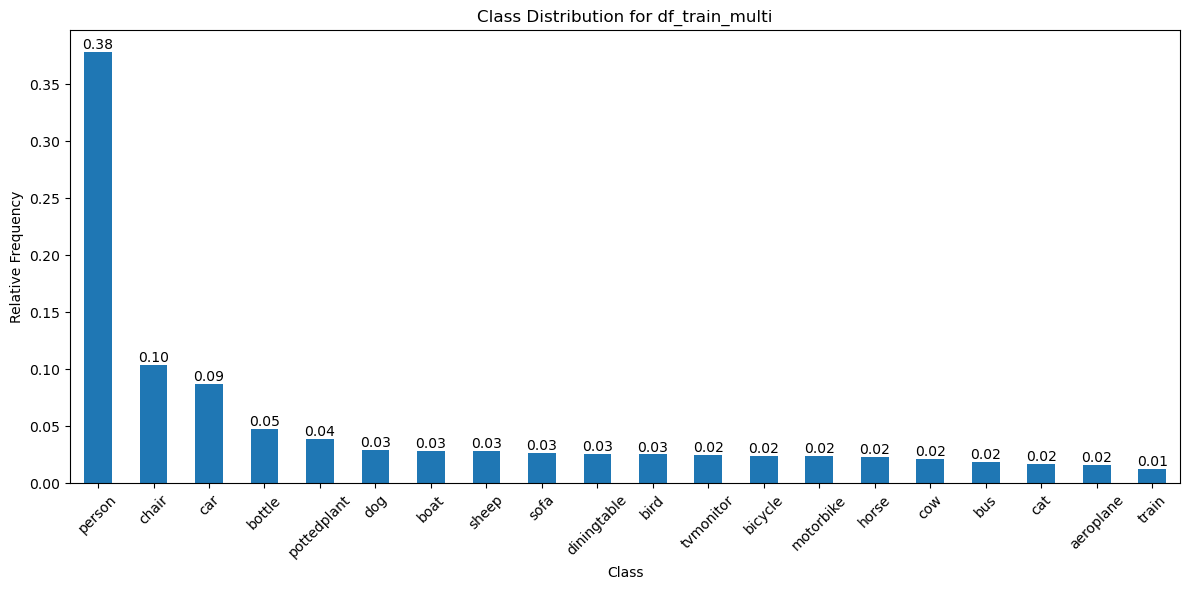

In [52]:
data_vis(df_train_multi,'df_train_multi')

In [53]:
# df_not_val[df_not_val['is_small_object']==1].value_counts()
df_not_val['is_small_object'].value_counts()

is_small_object
0    40301
1     5271
Name: count, dtype: int64

### 2.4.2 Sampling based on rule
Description:
- In view of the increase in data augmentation for small object & difficult recognition object, filter the data below the average number of bounding boxes in the multi-object recognition data.
- Conduct three experiments on multi-object data to obtain the best elimination effect data.

Details:
> - After excluding data whose bounding boxes are higher than the mean, there are 7503 samples remaining with a total of 21668 pieces of data
> - After performing targeted screening on multiple object, the final **multi-object samples are 2141 (7059 object)** (randomly eliminated, if run again the number will be different from the current one)
> - In order to keep the proportion of single/multi-object samples close to the original data, reduce the number of single-object samples to train_single_num = 1501** (randomly screened, the data is proportional to the deleted data above).
> - Finally combine the single/multi-object data: ** From 16062 samples (45572 objects), reduced to 3642 (8560 objects), the entropy increased from 2.506 to 2.922**

In [54]:
df_train_multi['bbx_num'].describe()

count    38951.000000
mean         6.521039
std          5.337744
min          2.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         42.000000
Name: bbx_num, dtype: float64

In [55]:
df_train_multi[df_train_multi['bbx_num']<=5]['class'].value_counts()

class
person         7452
car            1865
chair          1724
dog            1022
sofa            853
pottedplant     756
bottle          728
horse           678
tvmonitor       673
boat            655
cat             633
motorbike       619
bird            603
bicycle         576
cow             525
sheep           516
bus             512
aeroplane       474
train           423
diningtable     381
Name: count, dtype: int64

In [56]:
df_train_multi = df_train_multi[df_train_multi['bbx_num']<=5]


#### 2.4.2.1 Perform data filtering for multiple object
Here we conduct three experiences for testing the performance of the program, which are:

1.	Eliminate by proportion (entropy is 2.743) 
2.	Eliminate half of the samples (entropy is 2.802) 
3.	Eliminate until conditions are not met (entropy is 2.927) 

Finally, we choose the third experimental output with its best entropy, and the sample size was 2703 (7286 object).


In [57]:
train_multi_num = len(df_train_multi.groupby('filename').count())
print('image number of df_train_multi: ', train_multi_num)
df_train_multi['class'].value_counts()

image number of df_train_multi:  7503


class
person         7452
car            1865
chair          1724
dog            1022
sofa            853
pottedplant     756
bottle          728
horse           678
tvmonitor       673
boat            655
cat             633
motorbike       619
bird            603
bicycle         576
cow             525
sheep           516
bus             512
aeroplane       474
train           423
diningtable     381
Name: count, dtype: int64

##### **Experiment I：Eliminate by proportion**
> Set the expected threshold based on the proportion of each type of sample. **The obtained sample size is 4922 (13922 objects) and the entropy is 2.743**

In [58]:
train_threshold = int(train_multi_num * (1 - df_train_multi['class'].value_counts(normalize=True).max()))
train_threshold

4922

In [59]:
train_dropping = exclude_data(df_train_multi, train_threshold)

threshold: 4922
The sum of sample after dropping: 7403
current entropy: 2.511227567347512
The sum of sample after dropping: 7303
current entropy: 2.519964925236865
The sum of sample after dropping: 7203
current entropy: 2.5279083387393793
The sum of sample after dropping: 7103
current entropy: 2.5348039742714414
The sum of sample after dropping: 7003
current entropy: 2.54260119327471
The sum of sample after dropping: 6903
current entropy: 2.5506460922062857
The sum of sample after dropping: 6803
current entropy: 2.5591501424601075
The sum of sample after dropping: 6703
current entropy: 2.566556991697279
The sum of sample after dropping: 6603
current entropy: 2.5743528654014924
The sum of sample after dropping: 6503
current entropy: 2.58132681466079
The sum of sample after dropping: 6403
current entropy: 2.588963001574855
The sum of sample after dropping: 6303
current entropy: 2.5983278408190835
The sum of sample after dropping: 6203
current entropy: 2.607961855198122
The sum of sample 

In [60]:
print('image number of train_dropping: ', len(train_dropping.groupby('filename').count()))
train_dropping.reset_index(drop=True)

image number of train_dropping:  4903


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13917,sofa,88,157,500,375,1,1,1,2011_003259.jpg,500,...,1,0,3.863605,0.824000,0.581333,0.588000,0.709333,-0.193585,-0.542431,1
13918,person,51,173,352,375,1,0,1,2011_003259.jpg,500,...,1,0,3.863605,0.602000,0.538667,0.403000,0.730667,-0.507498,-0.618658,1
13919,chair,109,65,332,277,0,0,1,2011_003259.jpg,500,...,1,0,3.863605,0.446000,0.565333,0.441000,0.456000,-0.807436,-0.570340,1
13920,bicycle,132,245,186,332,0,0,1,2011_003261.jpg,375,...,1,0,3.328745,0.144000,0.174000,0.424000,0.577000,-1.937942,-1.748700,0


The entropy of train_dropping :
2.742785701545306


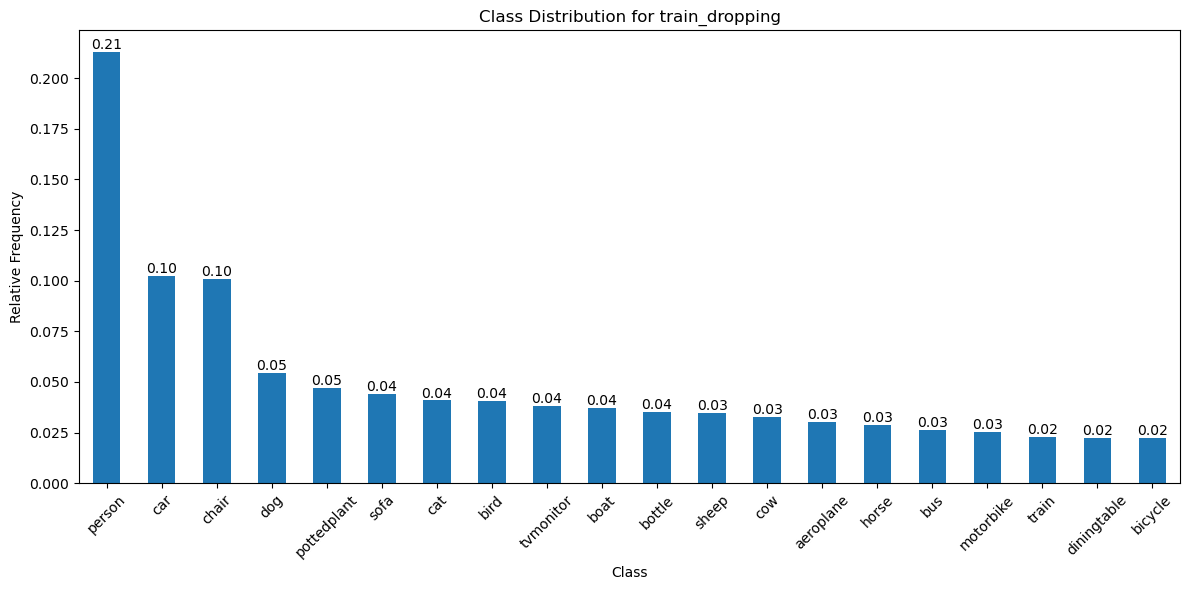

In [61]:
data_vis(train_dropping,'train_dropping')

##### **Experiment II：Eliminate half of the samples**
> Directly reduce to half of the original total sample size, **the obtained sample size is 3751 (12415 objects), and the entropy is 2.802**

In [62]:
train_threshold_half = int(train_multi_num / 2)
train_threshold_half

3751

In [63]:
train_dropping_half = exclude_data(df_train_multi, train_threshold_half)

threshold: 3751
The sum of sample after dropping: 7403
current entropy: 2.512048467467625
The sum of sample after dropping: 7303
current entropy: 2.5196909663294007
The sum of sample after dropping: 7203
current entropy: 2.527718778379046
The sum of sample after dropping: 7103
current entropy: 2.5349856361782055
The sum of sample after dropping: 7003
current entropy: 2.542459490845301
The sum of sample after dropping: 6903
current entropy: 2.548318180663205
The sum of sample after dropping: 6803
current entropy: 2.5557618514035005
The sum of sample after dropping: 6703
current entropy: 2.5636680921424326
The sum of sample after dropping: 6603
current entropy: 2.5735858264024687
The sum of sample after dropping: 6503
current entropy: 2.582413452353184
The sum of sample after dropping: 6403
current entropy: 2.5910441188621975
The sum of sample after dropping: 6303
current entropy: 2.5993201137386497
The sum of sample after dropping: 6203
current entropy: 2.608188442795507
The sum of samp

In [64]:
print('image number of train_dropping_half: ', len(train_dropping_half.groupby('filename').count()))
train_dropping_half.reset_index(drop=True)

image number of train_dropping_half:  4403


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12410,dog,246,130,398,218,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.304000,0.234667,0.644000,0.464000,-1.190728,-1.449589,0
12411,dog,5,124,287,265,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.564000,0.376000,0.292000,0.518667,-0.572701,-0.978166,0
12412,sofa,5,75,414,307,1,0,1,2011_003256.jpg,500,...,1,0,3.720121,0.818000,0.618667,0.419000,0.509333,-0.200893,-0.480189,0
12413,bicycle,132,245,186,332,0,0,1,2011_003261.jpg,375,...,1,0,3.328745,0.144000,0.174000,0.424000,0.577000,-1.937942,-1.748700,0


The entropy of train_dropping_half :
2.8021072231985213


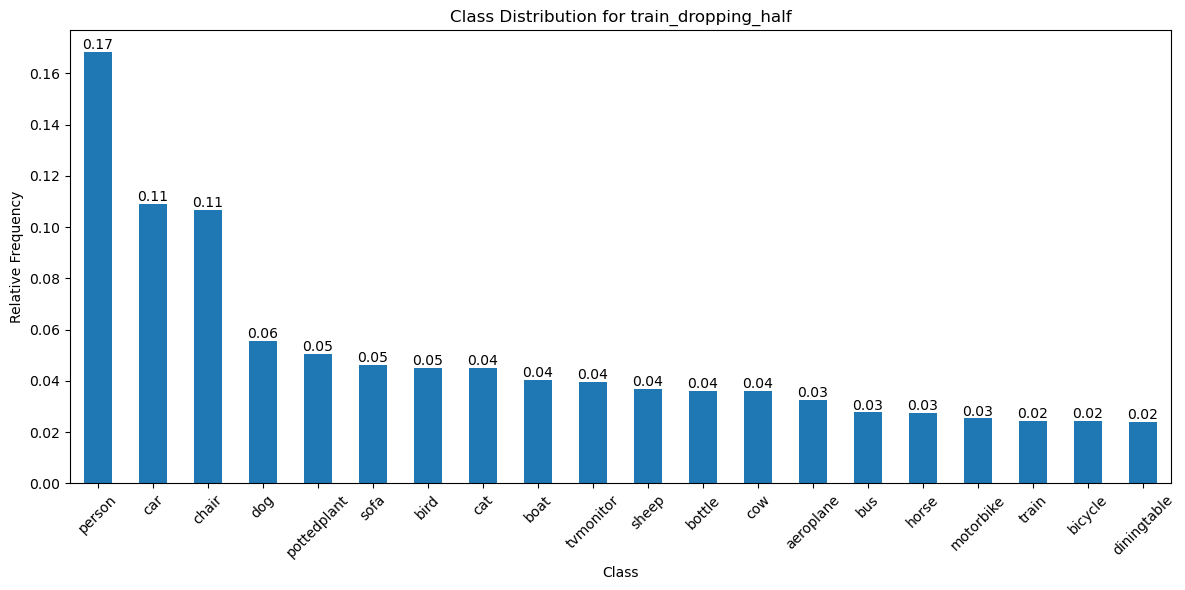

In [65]:
data_vis(train_dropping_half,'train_dropping_half')

##### **Experiment III：Eliminate until conditions are not met**
> Repeat the experiment to find the maximum value of the entropy change, and adjust the expected entropy value. **The obtained sample size is 2703 (7286 objects) and the entropy is 2.927**

In [66]:
train_dropping_0 = exclude_data(df_train_multi, 0, 100, 2.925)

threshold: 0
The sum of sample after dropping: 7403
current entropy: 2.512247893047284
The sum of sample after dropping: 7303
current entropy: 2.520349842108216
The sum of sample after dropping: 7203
current entropy: 2.5275259032411816
The sum of sample after dropping: 7103
current entropy: 2.5350677993442243
The sum of sample after dropping: 7003
current entropy: 2.5436149621934736
The sum of sample after dropping: 6903
current entropy: 2.550661730378562
The sum of sample after dropping: 6803
current entropy: 2.557893082051877
The sum of sample after dropping: 6703
current entropy: 2.56661606790513
The sum of sample after dropping: 6603
current entropy: 2.5747470115556252
The sum of sample after dropping: 6503
current entropy: 2.5830574415815546
The sum of sample after dropping: 6403
current entropy: 2.5908790772279207
The sum of sample after dropping: 6303
current entropy: 2.599514013886243
The sum of sample after dropping: 6203
current entropy: 2.607544394266078
The sum of sample af

In [67]:
print('image number of train_dropping_half: ', len(train_dropping_0.groupby('filename').count()))
train_dropping_0.reset_index(drop=True)

image number of train_dropping_half:  2703


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7281,bottle,130,259,148,305,0,0,0,2011_003254.jpg,375,...,1,1,3.740536,0.048000,0.092000,0.370667,0.564000,-3.036554,-2.385967,1
7282,sofa,1,267,66,464,1,1,0,2011_003254.jpg,375,...,1,0,3.740536,0.173333,0.394000,0.089333,0.731000,-1.752539,-0.931404,1
7283,dog,246,130,398,218,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.304000,0.234667,0.644000,0.464000,-1.190728,-1.449589,0
7284,dog,5,124,287,265,0,0,0,2011_003256.jpg,500,...,1,0,3.720121,0.564000,0.376000,0.292000,0.518667,-0.572701,-0.978166,0


The entropy of train_dropping_unlimit :
2.92724978183503


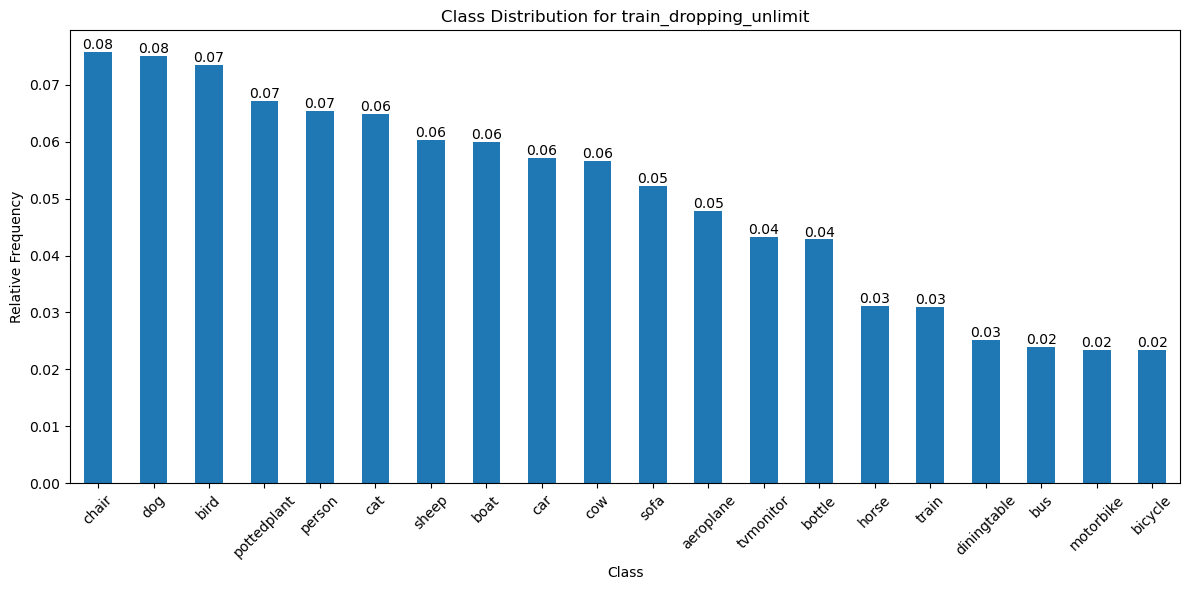

In [68]:
data_vis(train_dropping_0,'train_dropping_unlimit')

In [69]:
train_dropping_0['class'].value_counts()

class
chair          552
dog            547
bird           535
pottedplant    489
person         476
cat            472
sheep          439
boat           437
car            416
cow            413
sofa           381
aeroplane      349
tvmonitor      315
bottle         312
horse          227
train          226
diningtable    183
bus            175
motorbike      171
bicycle        171
Name: count, dtype: int64

##### **experiment result visualization**

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


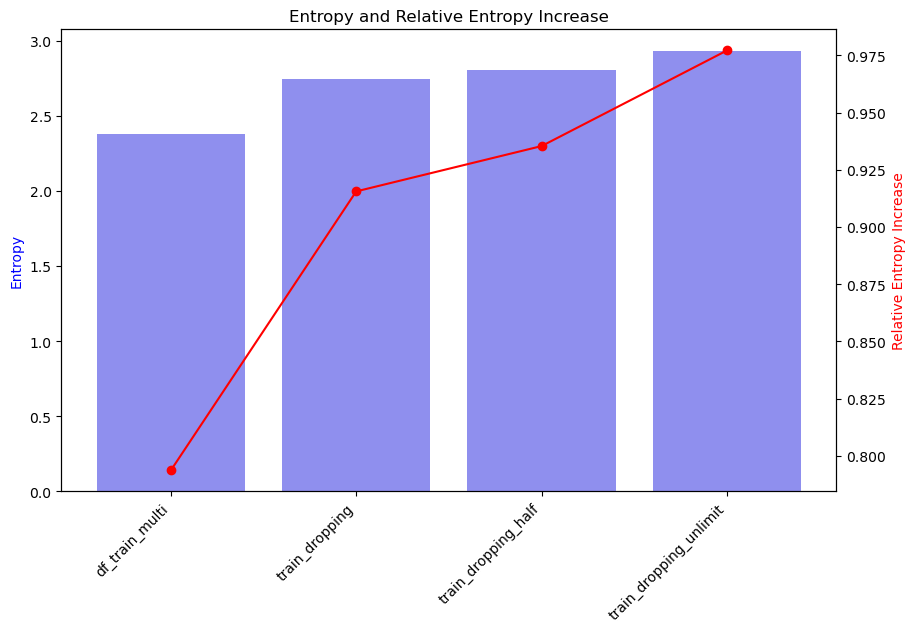

In [70]:
data = {
    'df_train_multi': {'entropy': 2.377618865, 'relative_entropy_increase': 0.793668675},
    'train_dropping': {'entropy': 2.742785702, 'relative_entropy_increase': 0.91556436},
    'train_dropping_half': {'entropy': 2.802107223, 'relative_entropy_increase': 0.93536637},
    'train_dropping_unlimit': {'entropy': 2.927249782, 'relative_entropy_increase': 0.977139983}
}

entropies = [data[key]['entropy'] for key in data]
rel_ent_inc = [data[key]['relative_entropy_increase'] for key in data]
labels = list(data.keys())

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=entropies, color='b', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Entropy', color='b')

ax2 = plt.gca().twinx()
ax2.plot(labels, rel_ent_inc, 'r-o')
ax2.set_ylabel('Relative Entropy Increase', color='r')

plt.title('Entropy and Relative Entropy Increase')
plt.show()


#### 2.4.2.2 Sampling for single object sample
> In order to ensure that the proportion of single-object samples and multi-object samples is similar to the original data, random data screening is performed according to the number of multi-object samples obtained.
>
The final train_single_selected contains 1501 samples (also the object number, because it is a single object sample)

In [71]:
train_multi_num_final = len(train_dropping_0.groupby('filename').count())
print('image number of train_dropping_0: ', train_multi_num_final)
# train_dropping_0['class'].value_counts()

image number of train_dropping_0:  2703


In [72]:
# mul_obj_select = len(df_train_multi.groupby('filename'))
train_single_num = int(train_multi_num_final*single_obj/mul_obj)
train_single_num

1895

In [73]:
df_train_single['class'].value_counts()

class
cat            925
dog            861
bird           759
person         634
aeroplane      597
car            501
train          456
boat           223
bicycle        203
horse          189
tvmonitor      185
motorbike      174
bottle         151
cow            151
chair          135
bus            131
sheep          120
sofa           109
pottedplant    103
diningtable     14
Name: count, dtype: int64

In [74]:
# Sampling on diningtable into df_train_single_without_diningtable
df_train_single_without_diningtable = df_train_single[df_train_single['class'] != 'diningtable']

# Randomly select train_single_num - 14 samples into the list
selected_filenames_list = list(df_train_single_without_diningtable.groupby('filename').groups.keys())

# sampling based on the list (select filename on the list)
random.seed(44)
train_filenames_selected_without_diningtable = random.sample(selected_filenames_list, train_single_num - 14)
train_filenames_selected_without_diningtable
df_sel_without_diningtable = df_train_single_without_diningtable[df_train_single_without_diningtable['filename'].isin(train_filenames_selected_without_diningtable)]

# merge two dataframe together
df_diningtable = df_train_single[df_train_single['class'] == 'diningtable']
train_single_selected = pd.concat([df_sel_without_diningtable, df_diningtable], ignore_index=True)

print('image number of train_single_selected: ', len(train_single_selected.groupby('filename').count()))
train_single_selected

image number of train_single_selected:  1895


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,car,141,50,500,330,1,0,-1,000007.jpg,500,...,0,0,5.198441,0.718000,0.840841,0.641000,0.570571,-0.331286,-0.173353,0
1,bicycle,92,72,305,473,0,0,-1,000016.jpg,334,...,0,0,3.866582,0.637725,0.802000,0.594311,0.545000,-0.449849,-0.220647,0
2,cat,4,77,320,252,0,0,-1,000099.jpg,500,...,0,0,5.791459,0.632000,0.466667,0.324000,0.438667,-0.458866,-0.762140,0
3,bird,17,12,482,235,0,0,-1,000109.jpg,500,...,0,0,5.645987,0.930000,0.877953,0.499000,0.486220,-0.072571,-0.130162,0
4,dog,66,121,440,276,0,0,-1,000120.jpg,500,...,0,0,4.986996,0.748000,0.387500,0.506000,0.496250,-0.290352,-0.948039,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,diningtable,1,82,384,288,1,0,0,2010_000938.jpg,384,...,0,0,3.075534,0.997396,0.715278,0.501302,0.642361,-0.002608,-0.335084,0
1891,diningtable,1,1,500,272,1,0,1,2010_004391.jpg,500,...,0,0,4.251757,0.998000,0.996324,0.501000,0.501838,-0.002002,-0.003683,0
1892,diningtable,1,1,499,375,0,0,0,2011_000461.jpg,500,...,0,0,3.416657,0.996000,0.997333,0.500000,0.501333,-0.004008,-0.002670,0
1893,diningtable,1,246,298,500,1,0,1,2011_000598.jpg,375,...,0,0,3.765264,0.792000,0.508000,0.398667,0.746000,-0.233194,-0.677274,0


In [75]:
train_single_selected['class'].value_counts()

class
cat            289
dog            231
bird           215
person         174
aeroplane      159
car            132
train          125
boat            68
motorbike       65
bicycle         64
horse           58
tvmonitor       46
bottle          43
chair           41
sheep           39
cow             34
bus             33
sofa            33
pottedplant     32
diningtable     14
Name: count, dtype: int64

#### 2.4.2.3 Data Merging
> consider df_train_selected as the output，and finally we get an outputing sample size：4598（9181 objects），with its entropy: 2.918

In [76]:
df_train_selected = pd.concat([train_dropping_0, train_single_selected], ignore_index=True)
print('image number of df_train_selected: ', len(df_train_selected.groupby('filename').count()))
df_train_selected.reset_index(drop=True)

image number of df_train_selected:  4598


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9176,diningtable,1,82,384,288,1,0,0,2010_000938.jpg,384,...,0,0,3.075534,0.997396,0.715278,0.501302,0.642361,-0.002608,-0.335084,0
9177,diningtable,1,1,500,272,1,0,1,2010_004391.jpg,500,...,0,0,4.251757,0.998000,0.996324,0.501000,0.501838,-0.002002,-0.003683,0
9178,diningtable,1,1,499,375,0,0,0,2011_000461.jpg,500,...,0,0,3.416657,0.996000,0.997333,0.500000,0.501333,-0.004008,-0.002670,0
9179,diningtable,1,246,298,500,1,0,1,2011_000598.jpg,375,...,0,0,3.765264,0.792000,0.508000,0.398667,0.746000,-0.233194,-0.677274,0


The entropy of df_train_selected :
2.9178723618100486


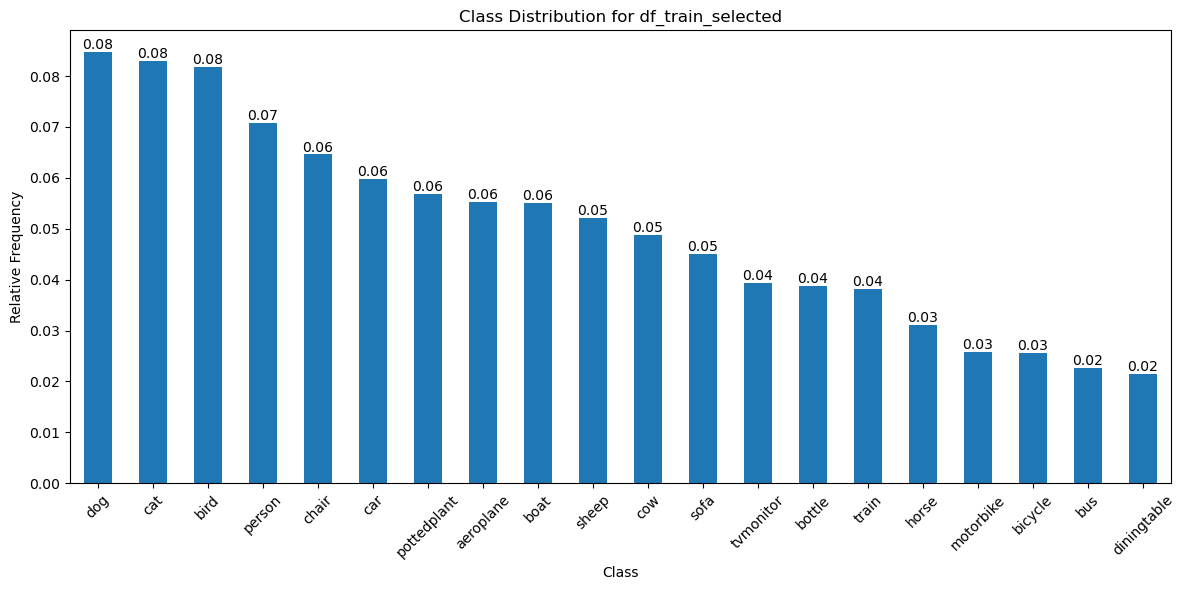

In [77]:
data_vis(df_train_selected,'df_train_selected')

In [78]:
df_train_selected['class'].value_counts()

class
dog            778
cat            761
bird           750
person         650
chair          593
car            548
pottedplant    521
aeroplane      508
boat           505
sheep          478
cow            447
sofa           414
tvmonitor      361
bottle         355
train          351
horse          285
motorbike      236
bicycle        235
bus            208
diningtable    197
Name: count, dtype: int64

### 2.4.3 Sampling based on niqe_score
> Filter data according to niqe to provide high-quality image data for data enhancement as much as possible

Problems:
- Among the samples targeting a single object, the number of samples in the dining table category is quite small (additional data enhancement may be required for them)

Finally, the data set df_niqe_select based on the filtering rules was obtained, with a total of 2236 samples (4661 objects) and an entropy of 2.906 (the class are relatively uniform).
The number of single/multi-object samples are: 857 and 1379 respectively, which is close to the original ratio. The output is csv, which can then be used for data augmentation.


In [79]:
df_train_selected['niqe_score'].describe()

count    9179.000000
mean        4.544421
std         1.455478
min         1.614321
25%         3.594367
50%         4.283350
75%         5.199778
max        15.613629
Name: niqe_score, dtype: float64

In [80]:
df_train_selected.groupby('class')['niqe_score'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
aeroplane,508.0,6.223840,2.232118,2.458006,4.711547,5.587636,7.585430,15.613629
bicycle,235.0,4.389234,1.156587,2.611494,3.524327,4.205898,5.067564,9.009518
bird,750.0,5.015985,1.883721,2.319673,3.681582,4.639929,5.692583,13.231775
boat,505.0,5.027238,1.487121,2.133739,4.035960,4.854174,5.567892,15.143206
bottle,355.0,4.247571,1.292148,2.051623,3.447764,4.021209,4.633375,10.697843
bus,208.0,4.304266,1.125208,2.309598,3.520255,3.993834,4.761922,8.050345
car,548.0,4.397484,1.076989,2.377488,3.721173,4.224174,4.940325,9.550614
cat,761.0,4.520678,1.331986,2.182022,3.547733,4.334594,5.287051,11.244922
chair,593.0,4.306868,1.179384,2.193620,3.529883,4.160924,4.798078,10.707185


In [81]:
df_niqe_select = df_train_selected[df_train_selected['niqe_score']<=4.3]
print('image number of df_niqe_select: ', len(df_niqe_select.groupby('filename').count()))
df_niqe_select

image number of df_niqe_select:  2236


,class,xmin,ymin,xmax,ymax,truncated,difficult,occluded,filename,width,...,is_multi_class,is_small_object,niqe_score,bbx_width,bbx_height,bbx_center_x,bbx_center_y,log_bbx_width,log_bbx_height,difficult_sum
0,chair,263,211,324,339,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.122000,0.341333,0.587000,0.733333,-2.103734,-1.074896,2
1,chair,165,264,253,372,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.176000,0.288000,0.418000,0.848000,-1.737271,-1.244795,2
2,chair,5,244,67,374,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.124000,0.346667,0.072000,0.824000,-2.087474,-1.059392,2
3,chair,241,194,295,299,0,0,-1,000005.jpg,500,...,0,0,3.480605,0.108000,0.280000,0.536000,0.657333,-2.225624,-1.272966,2
4,chair,277,186,312,220,1,1,-1,000005.jpg,500,...,0,0,3.480605,0.070000,0.090667,0.589000,0.541333,-2.659260,-2.400566,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174,diningtable,1,1,500,375,1,0,0,2009_004399.jpg,500,...,0,0,3.649282,0.998000,0.997333,0.501000,0.501333,-0.002002,-0.002670,0
9176,diningtable,1,82,384,288,1,0,0,2010_000938.jpg,384,...,0,0,3.075534,0.997396,0.715278,0.501302,0.642361,-0.002608,-0.335084,0
9177,diningtable,1,1,500,272,1,0,1,2010_004391.jpg,500,...,0,0,4.251757,0.998000,0.996324,0.501000,0.501838,-0.002002,-0.003683,0
9178,diningtable,1,1,499,375,0,0,0,2011_000461.jpg,500,...,0,0,3.416657,0.996000,0.997333,0.500000,0.501333,-0.004008,-0.002670,0


In [82]:
df_niqe_select.groupby('class')['niqe_score'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
aeroplane,87.0,3.788627,0.477404,2.458006,3.618502,3.962543,4.157833,4.287667
bicycle,132.0,3.599248,0.484559,2.611494,3.236994,3.699479,4.012714,4.296197
bird,305.0,3.502696,0.500179,2.319673,3.132090,3.568474,3.887047,4.282769
boat,175.0,3.677290,0.466245,2.133739,3.414474,3.764066,4.039068,4.283350
bottle,218.0,3.503865,0.556129,2.051623,3.110784,3.652845,3.933925,4.298514
bus,130.0,3.629284,0.385368,2.309598,3.379990,3.663720,3.955760,4.270072
car,299.0,3.658646,0.464931,2.377488,3.340749,3.789962,4.021190,4.296197
cat,366.0,3.473398,0.502004,2.182022,3.061035,3.519122,3.913291,4.298525
chair,345.0,3.584673,0.478278,2.193620,3.271662,3.610285,4.021209,4.298514


In [83]:
print('df_niqe_select: ')
df_niqe_select['class'].value_counts()

df_niqe_select: 


class
person         432
dog            413
cat            366
chair          345
pottedplant    310
bird           305
car            299
cow            245
sheep          225
bottle         218
sofa           209
boat           175
train          175
tvmonitor      169
horse          166
diningtable    139
bicycle        132
bus            130
motorbike      121
aeroplane       87
Name: count, dtype: int64

In [84]:
print('df_niqe_select single object:')
df_niqe_select[df_niqe_select['is_multi_object'] == 0]['class'].value_counts()

df_niqe_select single object:


class
cat            145
dog            122
person          97
bird            73
car             61
train           61
motorbike       37
horse           32
aeroplane       30
sheep           25
boat            25
bicycle         24
tvmonitor       21
bottle          18
chair           18
bus             18
sofa            16
cow             14
pottedplant     12
diningtable      8
Name: count, dtype: int64

In [85]:
df_niqe_select[df_niqe_select['is_multi_object'] == 0]['class'].value_counts().mean()

42.85

The entropy of df_niqe_select single object :
2.6720700395368375


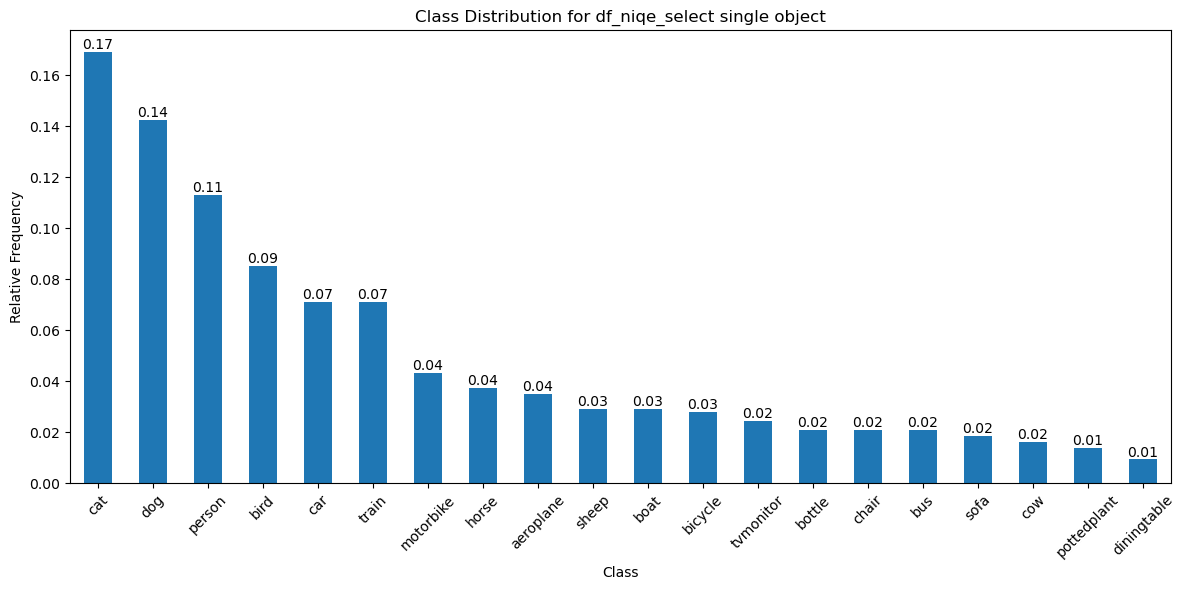

In [86]:
data_vis(df_niqe_select[df_niqe_select['is_multi_object'] == 0], 'df_niqe_select single object')

In [87]:
print('df_niqe_select multiple object: ')
df_niqe_select[df_niqe_select['is_multi_object'] == 1]['class'].value_counts()

df_niqe_select multiple object: 


class
person         335
chair          327
pottedplant    298
dog            291
car            238
bird           232
cow            231
cat            221
bottle         200
sheep          200
sofa           193
boat           150
tvmonitor      148
horse          134
diningtable    131
train          114
bus            112
bicycle        108
motorbike       84
aeroplane       57
Name: count, dtype: int64

sample sum after being selected by niqe_score:  2236
within this df, the sample sum of single object: 
857
the sample sum of multiple object: 
1379
The entropy of df_niqe_select :
2.9062991949311643


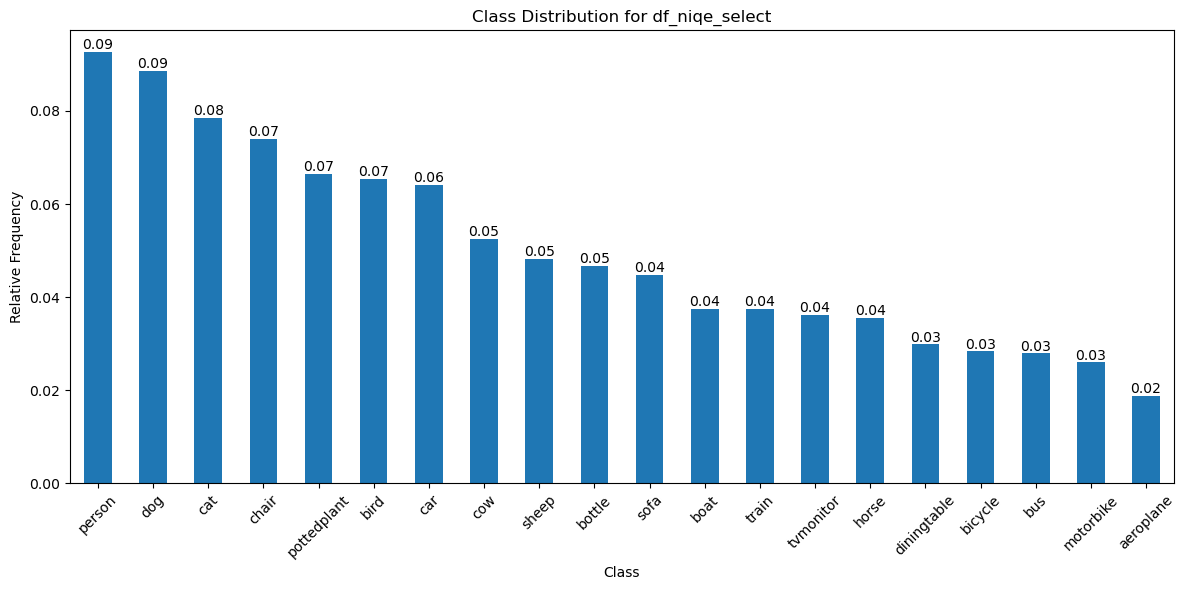

In [88]:
# print('the entropy:', get_entropy(df_niqe_select['class'].value_counts(normalize=True)))
print('sample sum after being selected by niqe_score: ', len(df_niqe_select.groupby('filename').count()))
print('within this df, the sample sum of single object: ')
print(len(df_niqe_select[df_niqe_select['is_multi_object'] == 0].groupby('filename').count()))
print('the sample sum of multiple object: ')
print(len(df_niqe_select[df_niqe_select['is_multi_object'] == 1].groupby('filename').count()))
data_vis(df_niqe_select, 'df_niqe_select')

In [89]:
df_niqe_select.to_csv('df_train_select.csv', encoding = 'utf-8', index = False)